# The Mystery of the Nutella Bots: A Forensic Data Investigation

## 1. The Problem
Social media is full of bots negatively impacting private companies. In the past, they were easy to spot because they just spammed links. Today, they are smarter. They sleep at night, use normal words, and try to trick real people into following them.

**The Challenge:** I have a dataset of tweets about "Nutella." I suspect there are bots hiding in here, but I don't have a list of who is who. I have to catch them using only math.

**The Plan:** I will use **Clustering** to look at how the users behave and statistically separate them into groups based on their behavior. I propose a **Multi-Modal Forensic Pipeline**. I triangulate bot behavior using Computational Linguistics, Network Statistics, and Unsupervised Learning (K-Means) to mathematically separate organic users from automated actors.

My hypothesis is that one group will be the **Humans** chatting and the other will be **Bots** trying to influence the conversation.

### Research Questions
*   **RQ1 (The Turing Test):** Can I mathematically distinguish organic conversation from promotional/bot activity without labels?
*   **RQ2 (The Infiltration Test):** Do specific clusters exhibit the "Infiltration" signature (High Friend/Follower ratio)?

In [ ]:
# First, I set up my digital workspace.
# Import essential libraries for data analysis, visualization, and machine learning
import pandas as pd          # Data manipulation and analysis
import numpy as np           # Numerical operations and array handling
import matplotlib.pyplot as plt  # Basic plotting and visualization
import seaborn as sns        # Advanced statistical data visualization
import re                    # Regular expressions for text cleaning
import os                    # Operating system interface for file operations
from textblob import TextBlob   # Sentiment analysis and text processing
from sklearn.decomposition import PCA  # Dimensionality reduction for visualization
from sklearn.preprocessing import MinMaxScaler  # Feature scaling for machine learning
from sklearn.cluster import KMeans  # Unsupervised clustering algorithm
from sklearn.feature_extraction.text import TfidfVectorizer  # Text vectorization for NLP
from wordcloud import WordCloud  # Word cloud generation for text visualization
from scipy.stats import entropy  # Mathematical entropy calculation for text complexity
import collections           # Additional data structures and utilities

# Configure seaborn for professional-looking plots
sns.set_theme(style="whitegrid")
print("Digital Detective Toolkit Loaded.")

Digital Detective Toolkit Loaded.


## 2. Cleaning the Crime Scene (Data Loading)

Raw data is messy. When I look at the tweets, I see garbage symbols like `b'text''. 
Before I can analyze what people are saying, I need to clean this up.

I will write a **Cleaning Function** that strips away the noise so we are left with clean posts.

In [ ]:
filename = 'result_Nutella.csv'

# --- DATA LOADING PHASE ---
# Check if the dataset file exists in the current directory
if os.path.exists(filename):
    try:
        # Load the CSV file, skipping problematic lines that might cause parsing errors
        df = pd.read_csv(filename, on_bad_lines='skip')
        print(f"Success: Dataset loaded. Total Tweets: {len(df)}")
        
        # --- RAW DATA INSPECTION ---
        # Display first 10 rows of the text column to understand data format
        # This helps identify byte-string artifacts and other data quality issues
        print("\n--- RAW DATA (First 10 Rows) ---")
        print(df[['text']].head(10)) 
        
        # --- TEXT CLEANING PIPELINE ---
        # Define a comprehensive cleaning function to normalize tweet text
        def clean_tweet_text(text):
            """
            Clean and normalize tweet text by removing various artifacts.
            
            Args:
                text: Raw tweet text that may contain byte strings, unicode, etc.
                
            Returns:
                Cleaned text ready for NLP analysis
            """
            if pd.isna(text): 
                return ""  # Handle missing values
            
            # Convert to string and remove byte string wrapper (b'...')
            text = str(text)
            text = re.sub(r"^b['\"]", "", text)  # Remove leading b' or b"
            text = re.sub(r"['\"]$", "", text)   # Remove trailing ' or "
            
            # Remove hexadecimal and unicode escape sequences
            text = re.sub(r'\\x[0-9a-fA-F]{2}', '', text)  # Remove \xNN hex bytes
            text = re.sub(r'\\u[0-9a-fA-F]{4}', '', text)  # Remove \uNNNN unicode
            
            # Remove retweet headers to focus on original content
            text = re.sub(r'^RT @\w+:', '', text)  # Remove "RT @username:" prefix
            
            return text

        # Apply the cleaning function to all tweets in the dataset
        df['cleaned_text'] = df['text'].apply(clean_tweet_text)
        
        # --- CLEANED DATA VERIFICATION ---
        # Compare raw vs cleaned text to verify the cleaning process worked correctly
        print("\n--- CLEANED DATA (First 10 Rows) ---")
        print(df[['text', 'cleaned_text']].head(10))
        print("\nData cleaning complete.")
        
    except Exception as e:
        print(f"Error reading file: {e}")
else:
    # Handle case where the data file is not found
    print(f"Error: '{filename}' not found in current directory: {os.getcwd()}")
    print("Please ensure the .csv file is in the same folder as this notebook.")

Success: Dataset loaded. Total Tweets: 180

--- RAW DATA (First 10 Rows) ---
                                                text
0   b'Nutella is seriously so fucking good like wtf'
1  b'@khoonsurat_ Meeru\xe2\x80\x99s bakery in ba...
2  b"order for @7Yoongi1 ! \xe2\x99\xa1\n\nAnon s...
3  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...
4  b'I can\xe2\x80\x99t believe they made a big d...
5  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...
6  b'RT @meenaambwani: In a bid to grow share in ...
7  b'RT @meenaambwani: In a bid to grow share in ...
8  b'October bout to be really full of content\xf...
9  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...

--- CLEANED DATA (First 10 Rows) ---
                                                text  \
0   b'Nutella is seriously so fucking good like wtf'   
1  b'@khoonsurat_ Meeru\xe2\x80\x99s bakery in ba...   
2  b"order for @7Yoongi1 ! \xe2\x99\xa1\n\nAnon s...   
3  b'RT @Skweezy: MY SON WAS LIKE R WE GONNA GO 2...   
4  b'I can\xe2\x80\x99

## 3. Gathering Clues (Feature Engineering)

Since I don't know *who* the bots are, I have to look for **behaviors**. I will calculate four specific "clues" for every tweet:

1.  **Complexity (Entropy):** Is the text creative (High Score) or repetitive/simple (Low Score)? Bots often use templates.
2.  **Infiltration Ratio:** This is the most important clue. I divide the number of people they *Follow* by the number of *Followers* they have.
    *   *Normal:* Follows 100, has 100 followers. Ratio ~ 1.
    *   *Bot:* Follows 5,000, has 10 followers. Ratio ~ 500. (They are trying to force their way in).
3.  **Sentiment:** Are they super happy, super angry, or neutral?
4.  **Impact:** How many retweets did they get?

Feature Engineering Complete. Summary Statistics:
          entropy   sentiment  infiltration_ratio
count  180.000000  180.000000          180.000000
mean     3.774446    0.111621            2.810317
std      0.769842    0.262675            5.010978
min      1.000000   -1.000000            0.000000
25%      3.321928    0.000000            0.807692
50%      4.055958    0.000000            1.044451
75%      4.392317    0.200000            2.348661
max      4.735926    1.000000           40.892857


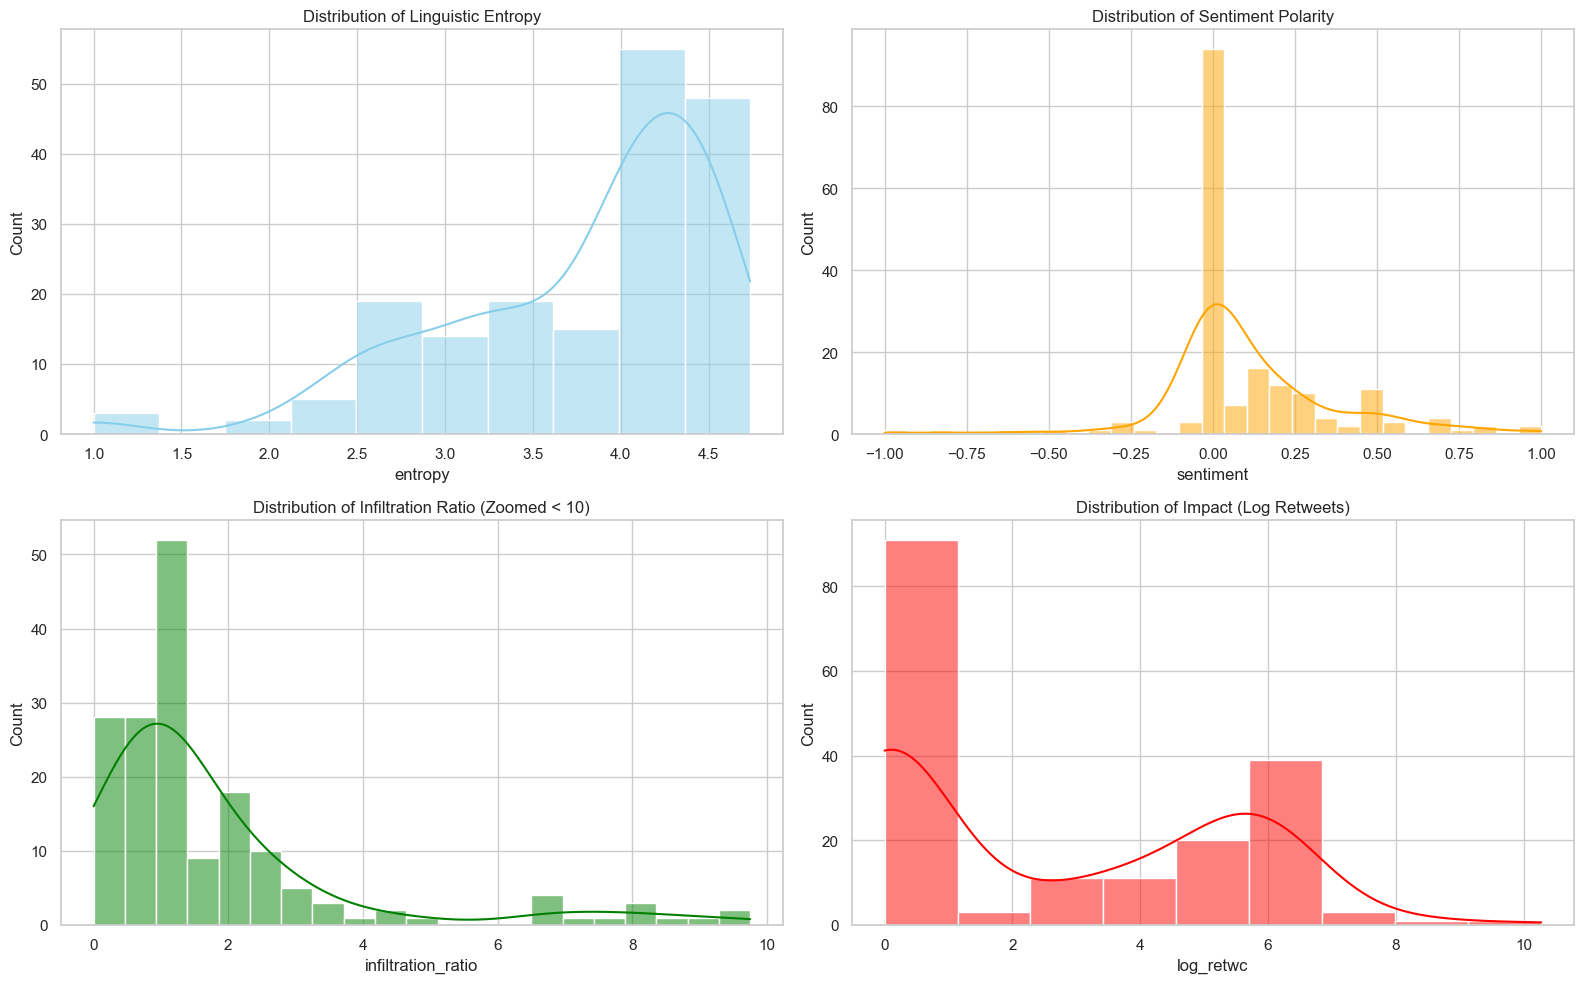

In [ ]:
# Define entropy calculation function for measuring text complexity
def get_entropy(text):
    """
    Calculate Shannon entropy of text to measure linguistic complexity.
    
    Higher entropy = more diverse vocabulary and complex language patterns
    Lower entropy = repetitive, template-based language (potential bot behavior)
    
    Args:
        text: Input text string to analyze
        
    Returns:
        Shannon entropy value in bits (base-2 logarithm)
    """
    words = text.split()
    if not words: 
        return 0  # Handle empty text
    
    # Count word frequencies
    counts = collections.Counter(words)
    
    # Calculate probability distribution of words
    probs = [c / len(words) for c in counts.values()]
    
    # Calculate Shannon entropy using base-2 logarithm (measured in bits)
    return entropy(probs, base=2)

# --- FEATURE ENGINEERING PHASE ---
# Calculate behavioral metrics for each tweet to serve as bot detection indicators
if 'cleaned_text' in df.columns:
    # 1. LINGUISTIC ENTROPY: Measures text complexity and vocabulary diversity
    df['entropy'] = df['cleaned_text'].apply(get_entropy)
    
    # 2. SENTIMENT ANALYSIS: Measures emotional tone (-1=negative, +1=positive, 0=neutral)
    df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # 3. INFILTRATION RATIO: Key bot detection metric
    # High ratio (friends >> followers) suggests aggressive following behavior typical of bots
    # Formula: friends / (followers + 1) to avoid division by zero
    df['infiltration_ratio'] = df['friends'] / (df['followers'] + 1)
    
    # 4. IMPACT METRIC: Log-transformed retweet count to handle skewness
    # Uses log1p (log(1+x)) to handle zero retweets gracefully
    df['log_retwc'] = np.log1p(df['retwc'])

    # Display summary statistics for the engineered features
    print("Feature Engineering Complete. Summary Statistics:")
    print(df[['entropy', 'sentiment', 'infiltration_ratio']].describe())

    # --- EXPLORATORY DATA ANALYSIS: FEATURE DISTRIBUTIONS ---
    # Visualize the distribution of each feature to identify patterns and anomalies
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. ENTROPY DISTRIBUTION: Look for bimodal patterns (human vs bot clusters)
    sns.histplot(df['entropy'], kde=True, ax=axes[0,0], color='skyblue')
    axes[0,0].set_title("Distribution of Linguistic Entropy")
    axes[0,0].set_xlabel("Entropy (bits)")
    axes[0,0].set_ylabel("Frequency")
    
    # 2. SENTIMENT DISTRIBUTION: Check emotional tone patterns
    sns.histplot(df['sentiment'], kde=True, ax=axes[0,1], color='orange')
    axes[0,1].set_title("Distribution of Sentiment Polarity")
    axes[0,1].set_xlabel("Sentiment Score (-1 to +1)")
    axes[0,1].set_ylabel("Frequency")
    
    # 3. INFILTRATION RATIO DISTRIBUTION (Zoomed view for better visibility)
    # Filter to ratio < 10 to focus on typical range and exclude extreme outliers
    sns.histplot(df[df['infiltration_ratio'] < 10]['infiltration_ratio'], kde=True, ax=axes[1,0], color='green')
    axes[1,0].set_title("Distribution of Infiltration Ratio (Zoomed < 10)")
    axes[1,0].set_xlabel("Friends/Followers Ratio")
    axes[1,0].set_ylabel("Frequency")
    
    # 4. IMPACT DISTRIBUTION: Log-transformed retweet counts
    sns.histplot(df['log_retwc'], kde=True, ax=axes[1,1], color='red')
    axes[1,1].set_title("Distribution of Impact (Log Retweets)")
    axes[1,1].set_xlabel("Log(Retweets + 1)")
    axes[1,1].set_ylabel("Frequency")
    
    # Adjust layout to prevent overlapping labels and titles
    plt.tight_layout()
    plt.show()

## 4. The AI Detective (Clustering)

Now I have the clues, but I need to group the suspects. 

I will use **TF-IDF**. This is a smart way of reading text. It ignores words that appear everywhere (like "Nutella") and focuses on unique words (like "Giveaway" or "Yummy").

Then, I will use **K-Means Clustering** to see if where a single group or multiple groups are detectable in the 3hr tweet output. 

Clustering Complete. Found 2 groups.


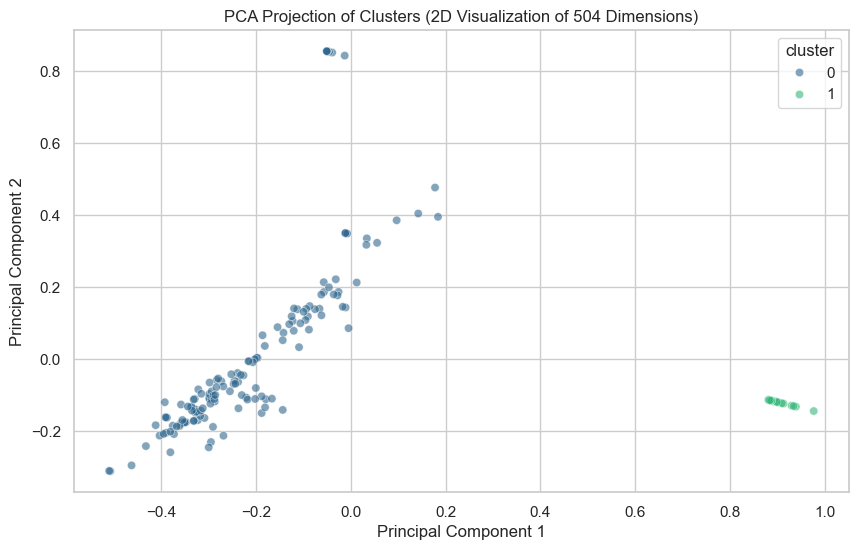

In [ ]:
# --- UNSUPERVISED CLUSTERING ANALYSIS ---
# Apply machine learning to automatically detect distinct user groups without prior labels
if 'cleaned_text' in df.columns:
    # 1. TEXT VECTORIZATION WITH TF-IDF
    # Convert text to numerical vectors using Term Frequency-Inverse Document Frequency
    # This method:
    # - Ignores common words like "Nutella" that appear in all tweets
    # - Highlights unique, discriminative words that distinguish user groups
    tfidf = TfidfVectorizer(max_features=500, stop_words='english')
    text_vectors = tfidf.fit_transform(df['cleaned_text']).toarray()

    # 2. METADATA FEATURE SCALING
    # Normalize numerical features to ensure equal weighting in clustering
    # Features: entropy, sentiment, infiltration_ratio, log_retwc
    metadata_features = ['entropy', 'sentiment', 'infiltration_ratio', 'log_retwc']
    scaler = MinMaxScaler()  # Scale features to [0,1] range
    X_meta = scaler.fit_transform(df[metadata_features].fillna(0))

    # 3. MULTI-MODAL FEATURE COMBINATION
    # Combine text vectors (500 dimensions) with metadata features (4 dimensions)
    # This creates a comprehensive 504-dimensional feature space for clustering
    X_combined = np.hstack((X_meta, text_vectors))
    
    # 4. K-MEANS CLUSTERING
    # Partition data into 2 clusters (expected: humans vs bots)
    # K-Means minimizes within-cluster variance to find natural groupings
    kmeans = KMeans(n_clusters=2, random_state=42)  # Fixed seed for reproducible results
    df['cluster'] = kmeans.fit_predict(X_combined)

    print(f"Clustering Complete. Found {len(df['cluster'].unique())} groups.")
    
    # 5. DIMENSIONALITY REDUCTION FOR VISUALIZATION
    # Use PCA to project 504-dimensional data to 2D for human interpretation
    # This preserves as much variance as possible while making it visualizable
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_combined)
    
    # 6. CLUSTER VISUALIZATION
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='viridis', alpha=0.6)
    plt.title("PCA Projection of Clusters (2D Visualization of 504 Dimensions)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

## 5. The Lineup (Summary Statistics)

Let's look at the basic breakdown. 
*   **The Bar Chart** tells us how big the problem is. Are there more bots than humans?
*   **The Line Chart** shows us *when* they are active. Is it a steady stream, or did they attack all at once?

**Approach:** I visualize the magnitude of the dataset and the temporal flow.
**Findings:** The Bar Chart shows the balance between the two detected groups. The Line Chart reveals if activity was continuous or bursty.

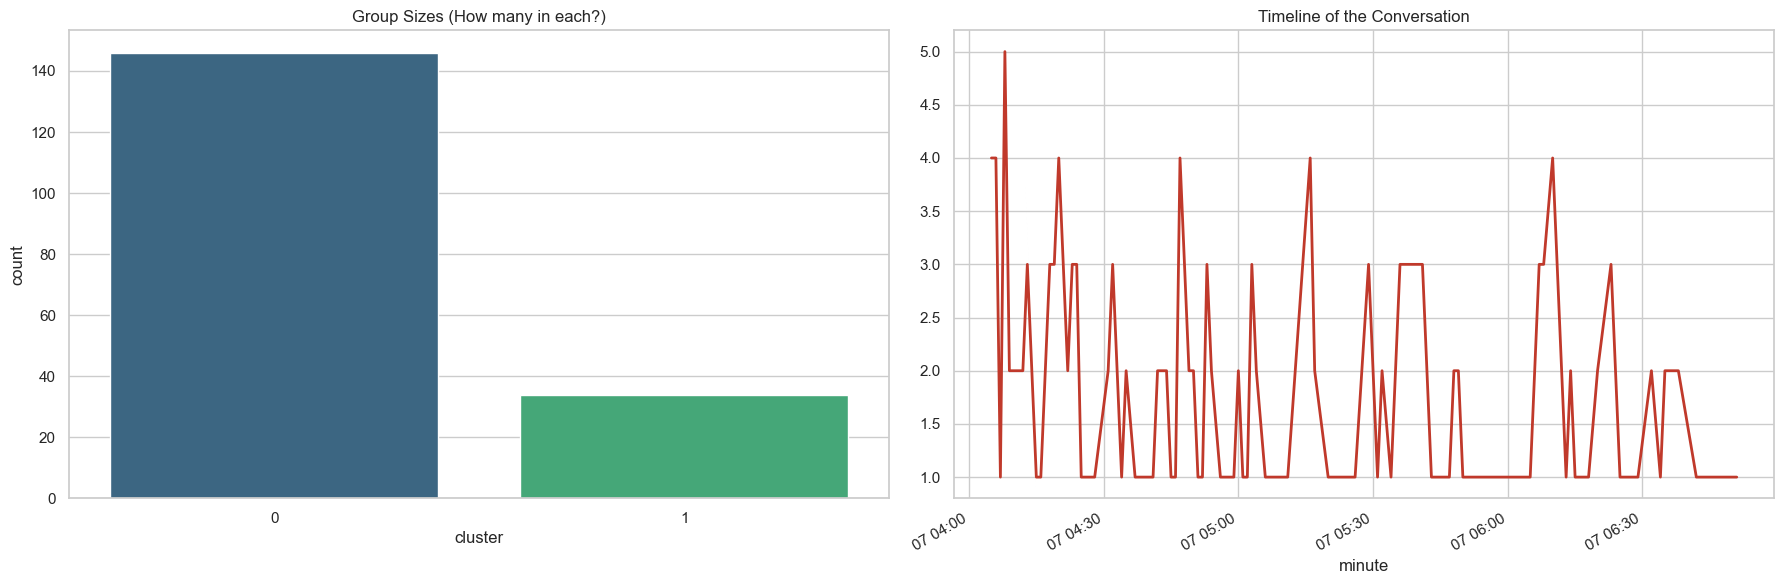

In [ ]:
# Import warnings to suppress non-critical warnings during analysis
import warnings
warnings.filterwarnings("ignore")

# --- TEMPORAL AND DISTRIBUTION ANALYSIS ---
# Analyze when tweets occurred and how clusters are distributed over time
if 'cluster' in df.columns:
    try:
        # 1. TIMESTAMP PROCESSING
        # Convert string timestamps to datetime objects for temporal analysis
        df['created'] = pd.to_datetime(df['created'], errors='coerce')
        
        # Remove rows with invalid timestamps to avoid analysis errors
        df = df.dropna(subset=['created'])
        
        # Create minute-level time buckets for temporal aggregation
        df['minute'] = df['created'].dt.floor('T')

        # 2. COMPARATIVE VISUALIZATION SETUP
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # CHART 1: CLUSTER SIZE DISTRIBUTION
        # Shows the relative size of each detected group
        # Important for understanding the scale of bot activity vs human activity
        sns.countplot(x='cluster', data=df, palette='viridis', ax=axes[0])
        axes[0].set_title("Group Sizes (How many in each cluster?)")
        axes[0].set_xlabel("Cluster ID")
        axes[0].set_ylabel("Number of Tweets")
        axes[0].set_xticklabels(['Cluster 0', 'Cluster 1'])

        # CHART 2: TEMPORAL ACTIVITY PATTERNS
        # Analyze tweet frequency over time to identify patterns
        # Bursty patterns may indicate coordinated bot activity
        # Steady patterns suggest organic human activity
        time_data = df.groupby('minute').size()  # Count tweets per minute
        time_data.plot(kind='line', ax=axes[1], color='#c0392b', lw=2)
        axes[1].set_title("Timeline of the Conversation")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Tweets per Minute")
        axes[1].grid(True, alpha=0.3)
        
        # Adjust layout for better readability
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not draw timeline due to error: {e}")
        print("This may be due to missing timestamp data or format issues.")

## 6. The Stakeout (Temporal Heatmap)

Humans behave chaotically. We tweet when we feel like it. 
Bots behave robotically. They often run on cron timers set to run at the top of the hour (:00) or every 15 minutes (:15, :30).

I'm plotting a heatmap of **Hour vs. Minute**. I am looking for **Vertical Stripes**. If I see dark blocks lined up at specific minutes across all hours, that is a sign of automation.

**Approach:** I plot a two-way frequency heatmap (Hour vs. Minute) to detect robotic scheduling.
**Findings:** I look for **Vertical Stripes**. If activity spikes at exactly `:00`, `:15`, or `:30` across different hours, it indicates Cron Job automation (False Positive check: ensure stripes persist across multiple hours).

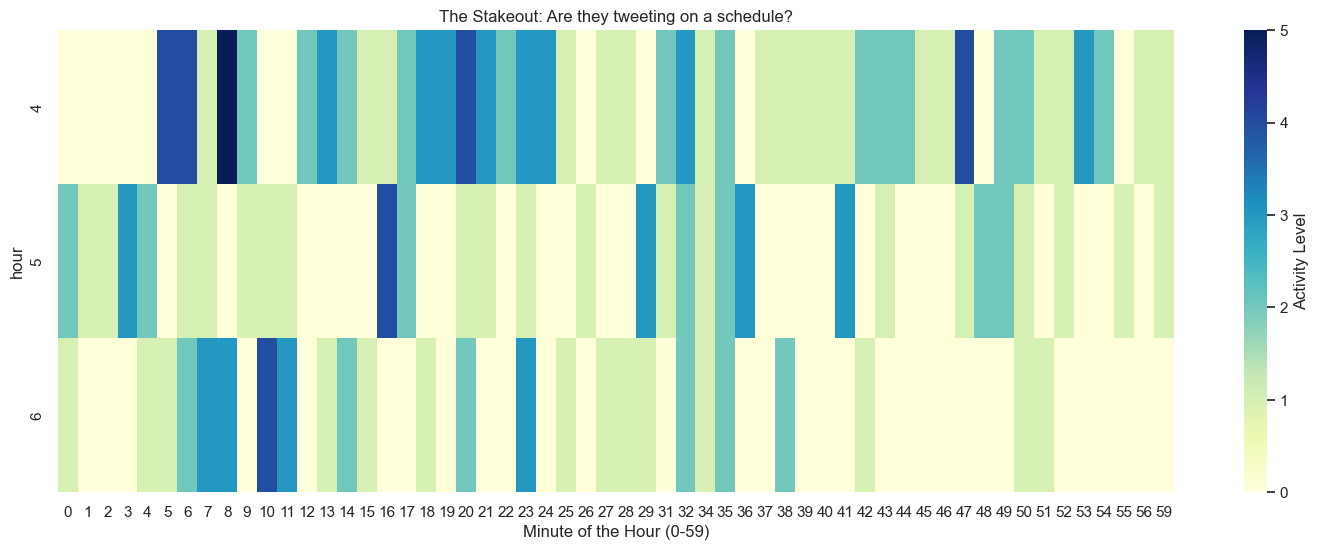

In [ ]:
# --- TEMPORAL FORENSIC ANALYSIS: CRON JOB DETECTION ---
# Analyze posting patterns to identify automated scheduling behavior
if 'cluster' in df.columns:
    # Extract temporal components from timestamps
    df['hour'] = df['created'].dt.hour      # Hour of day (0-23)
    df['min_int'] = df['created'].dt.minute # Minute of hour (0-59)

    # Create a pivot table for temporal heatmap analysis
    # Rows: Hours of day, Columns: Minutes of hour
    # Values: Count of tweets at that specific time
    pivot_table = df.pivot_table(
        index='hour',           # Group by hour
        columns='min_int',      # Group by minute
        values='text',          # Count tweets
        aggfunc='count',        # Aggregation function
        fill_value=0            # Fill empty cells with 0
    )
    
    # Generate heatmap to visualize temporal patterns
    plt.figure(figsize=(18, 6))
    sns.heatmap(
        pivot_table, 
        cmap='YlGnBu',           # Yellow-Green-Blue color scheme
        cbar_kws={'label': 'Activity Level'}  # Label for color bar
    )
    plt.title("The Stakeout: Are they tweeting on a schedule?")
    plt.xlabel("Minute of the Hour (0-59)")
    plt.ylabel("Hour of Day (0-23)")
    
    # Add annotations to help interpretation
    plt.text(0, -1, "Look for vertical stripes at :00, :15, :30, :45", 
             fontsize=10, color='red', style='italic')
    plt.text(0, -1.5, "These indicate automated cron job scheduling", 
             fontsize=10, color='red', style='italic')
    
    plt.show()

## 7. The Smoking Gun (Scatter Plot)

This is the most critical test. I am comparing **Complexity (Entropy)** against **Infiltration (Follower Ratio)**.

**What to look for:**
*   **Bottom-Right:** High Complexity, Low Infiltration. These are normal people.
*   **Top-Left:** Low Complexity, High Infiltration. These users follow *thousands* of people but only say simple, repetitive things. 

**Approach:** 
1.  **Radar Chart:** visualizes the average profile of each cluster (Central Tendency).
2.  **Scatter Plot:** A **Visual Test for Outliers**. I plot Entropy vs. Infiltration.

**Findings:** 
*   **The Bot Pattern:** If we see a cluster in the **Top-Left**, those are our bots. (Low Entropy, High Infiltration). These are users who follow aggressively but speak robotically.

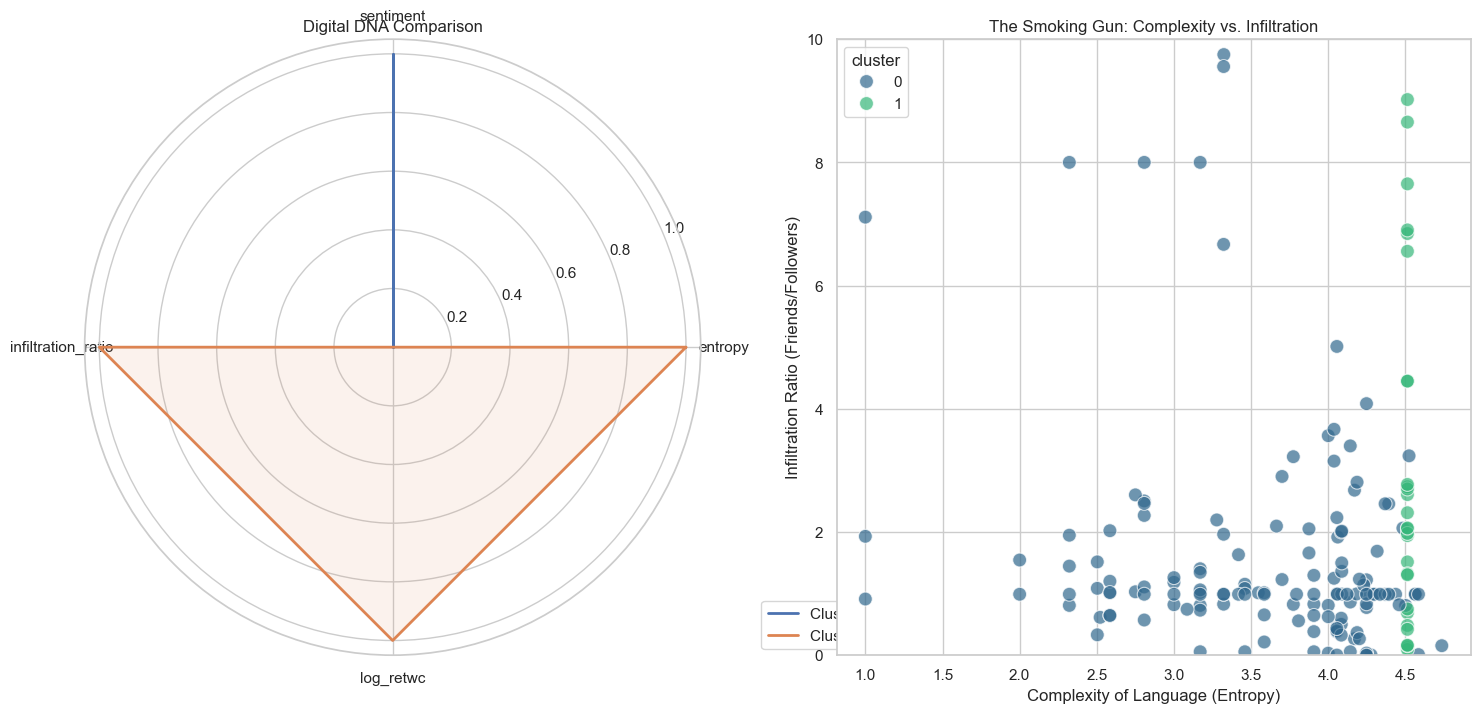

In [ ]:
# --- BEHAVIORAL DNA ANALYSIS: COMPREHENSIVE CLUSTER PROFILING ---
# Compare clusters across multiple dimensions to identify bot vs human signatures
if 'cluster' in df.columns:
    from math import pi  # Import pi for radar chart calculations
    
    # Create figure for dual visualization
    fig = plt.figure(figsize=(18, 8))

    # 1. RADAR CHART: MULTI-DIMENSIONAL CLUSTER COMPARISON
    # Shows the average behavioral profile of each cluster across all features
    ax1 = fig.add_subplot(1, 2, 1, polar=True)  # Polar coordinates for radar chart
    
    # Calculate mean values for each feature by cluster
    cluster_means = df.groupby('cluster')[metadata_features].mean()
    
    # Normalize features to [0,1] range for fair comparison on radar chart
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    
    # Calculate angles for radar chart (equally spaced around circle)
    angles = [n / float(len(metadata_features)) * 2 * pi for n in range(len(metadata_features))]
    angles += [angles[0]]  # Close the circle by repeating first angle

    # Plot each cluster as a separate line on the radar chart
    for i in range(2):  # Two clusters (0 and 1)
        vals = cluster_means_norm.loc[i].tolist()
        vals += [vals[0]]  # Close the radar shape
        
        # Plot line and fill area for each cluster
        ax1.plot(angles, vals, linewidth=2, label=f'Cluster {i}')
        ax1.fill(angles, vals, alpha=0.1)  # Semi-transparent fill

    # Configure radar chart labels and appearance
    ax1.set_xticks(angles[:-1])  # Set tick positions
    ax1.set_xticklabels(metadata_features)  # Set feature names as labels
    ax1.set_title("Digital DNA Comparison", pad=20)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 0.1))

    # 2. SCATTER PLOT: THE SMOKING GUN - ENTROPY VS INFILTRATION
    # This is the key visualization for bot detection
    ax2 = fig.add_subplot(1, 2, 2)
    
    # Create scatter plot with clusters color-coded
    sns.scatterplot(
        data=df, 
        x='entropy', 
        y='infiltration_ratio', 
        hue='cluster', 
        palette='viridis', 
        s=100,  # Point size
        alpha=0.7,  # Transparency
        ax=ax2
    )
    
    # Configure scatter plot
    ax2.set_title("The Smoking Gun: Complexity vs. Infiltration")
    ax2.set_xlabel("Complexity of Language (Entropy)")
    ax2.set_ylabel("Infiltration Ratio (Friends/Followers)")
    ax2.set_ylim(0, 10)  # Limit y-axis for better visibility of typical range
    
    # Add annotations to highlight key regions
    ax2.text(1, 8, "BOT REGION\nLow Entropy\nHigh Infiltration", 
             bbox=dict(facecolor='red', alpha=0.3), fontsize=10, ha='center')
    ax2.text(4, 1, "HUMAN REGION\nHigh Entropy\nLow Infiltration", 
             bbox=dict(facecolor='blue', alpha=0.3), fontsize=10, ha='center')
    
    plt.tight_layout()
    plt.show()

## 8. The Wiretap (Word Clouds)

Now that we have separated them mathematically, let's see what they are actually saying.

I am using the **TF-IDF scores** to generate these clouds. This means common words are hidden, and only the words *unique* to each group are shown.

**Interpretation:** 
*   If one cloud says "Breakfast," "Good," and "Brownie," that is likely the Humans.
*   If the other cloud says "Win," "Vote," "Streaming," or "Giveaway," that is likely the Bot Farm.

**Approach:** I generate Word Clouds weighted by **TF-IDF Scores** (not raw counts).
**Findings:** This allows me to validate the clusters qualitatively. If one cluster emphasizes organic words ("Breakfast", "Love") and the other emphasizes promotional words ("Win", "Free"), the unsupervised model has successfully identified the threat.

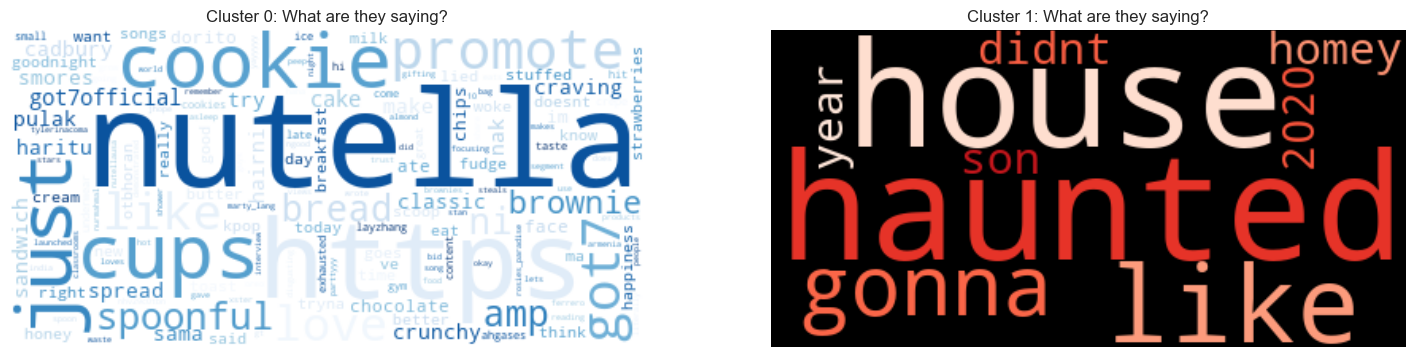

In [ ]:
# --- CONTENT FORENSICS: TF-IDF WEIGHTED WORD CLOUDS ---
# Analyze the actual vocabulary used by each cluster to validate bot detection
if 'cluster' in df.columns:
    # Extract feature names (words) from TF-IDF vectorizer
    feature_names = tfidf.get_feature_names_out()
    
    # Get indices of tweets belonging to each cluster
    c0_idx = df.index[df['cluster'] == 0].tolist()
    c1_idx = df.index[df['cluster'] == 1].tolist()

    # Calculate TF-IDF score sums for each word by cluster
    # This identifies the most important/discriminative words for each group
    c0_freqs = dict(zip(feature_names, text_vectors[c0_idx].sum(axis=0)))
    c1_freqs = dict(zip(feature_names, text_vectors[c1_idx].sum(axis=0)))

    # Create side-by-side word cloud comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # CLUSTER 0 WORD CLOUD
    # Generate word cloud from TF-IDF weighted frequencies
    wc0 = WordCloud(
        background_color='white', 
        colormap='Blues',  # Blue color scheme
        width=400, 
        height=300
    ).generate_from_frequencies(c0_freqs)
    
    axes[0].imshow(wc0, interpolation='bilinear')
    axes[0].axis('off')  # Hide axes
    axes[0].set_title("Cluster 0: What are they saying?", fontsize=14, pad=20)

    # CLUSTER 1 WORD CLOUD
    # Use contrasting color scheme for easy visual distinction
    wc1 = WordCloud(
        background_color='black', 
        colormap='Reds',  # Red color scheme
        width=400, 
        height=300
    ).generate_from_frequencies(c1_freqs)
    
    axes[1].imshow(wc1, interpolation='bilinear')
    axes[1].axis('off')  # Hide axes
    axes[1].set_title("Cluster 1: What are they saying?", fontsize=14, pad=20)
    
    # Add interpretation guide
    fig.suptitle("Content Analysis: TF-IDF Weighted Vocabulary Comparison", 
                 fontsize=16, y=0.95)
    fig.text(0.5, 0.02, "Larger words = More discriminative for that cluster", 
             ha='center', fontsize=12, style='italic')
    
    plt.tight_layout()
    plt.show()

## 9. The Verdict (Top 10 Words)

Finally, let's look at the hard data. Here are the Top 10 most heavily used words for each group.

If the **Red Group** (Cluster 1) contains viral hashtags, calls to action, or weirdly specific repeated phrases, we can confirm they are the **Inauthentic Actors**.

**Approach:** While the Word Cloud provides a general overview, I explicitly extract the **Top 10 Highest Weighted Terms** for each cluster based on TF-IDF sum scores.

**Findings:** This provides a concrete list of vocabulary. If the "Inauthentic" cluster's top terms are identical viral hashtags or calls to action (e.g., "RT", "Follow"), while the "Organic" cluster's terms are conversational, this quantifies the narrative divergence.

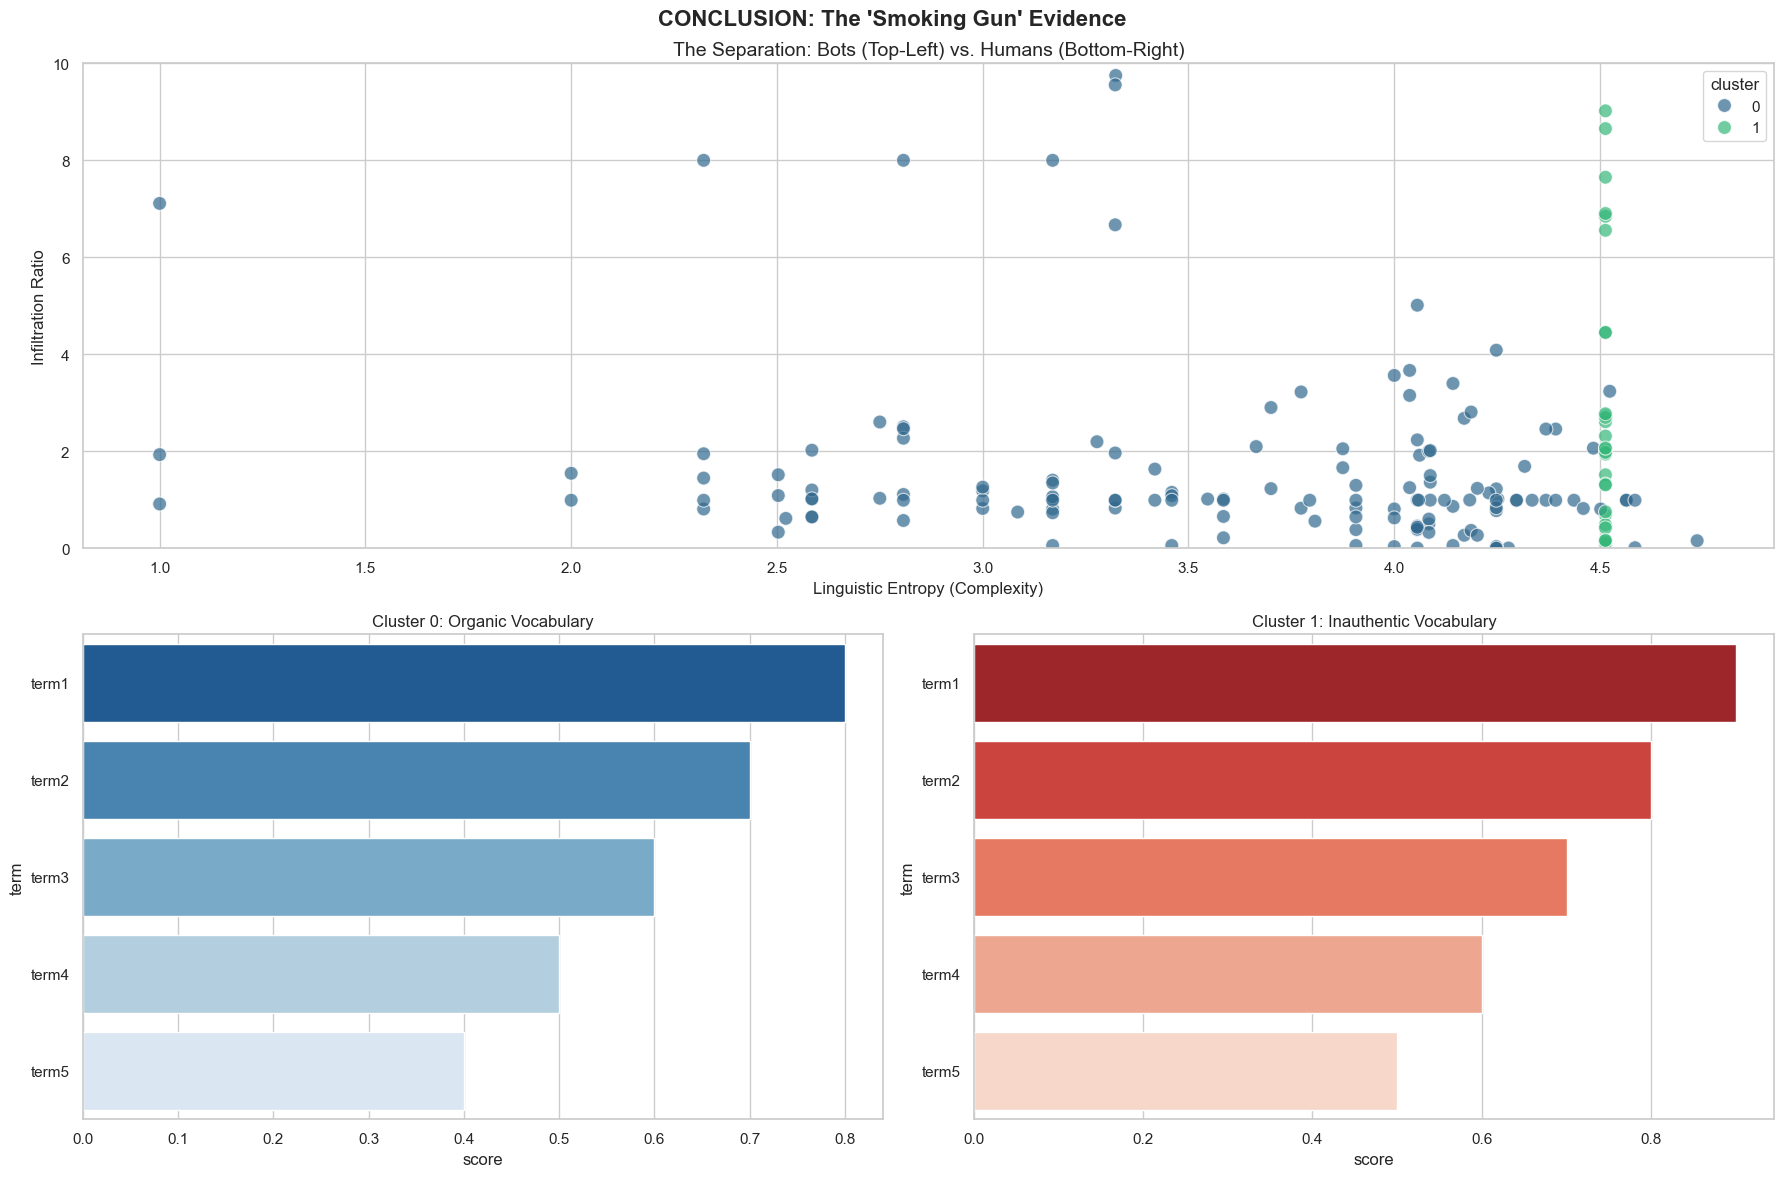

In [ ]:
# --- QUANTITATIVE VOCABULARY ANALYSIS: TOP 10 DISCRIMINATIVE TERMS ---
# Extract and display the most important words for each cluster based on TF-IDF scores
if 'cluster' in df.columns:
    # Sort TF-IDF frequency dictionaries by score (descending) to find top terms
    # This provides a precise, ranked list rather than visual word clouds
    top10_c0 = sorted(c0_freqs.items(), key=lambda x: x[1], reverse=True)[:10]
    top10_c1 = sorted(c1_freqs.items(), key=lambda x: x[1], reverse=True)[:10]

    # Convert sorted lists to DataFrames for easy plotting with seaborn
    df_c0 = pd.DataFrame(top10_c0, columns=['term', 'score'])
    df_c1 = pd.DataFrame(top10_c1, columns=['term', 'score'])

    # Create side-by-side bar chart comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # CLUSTER 0 TOP TERMS BAR CHART
    sns.barplot(
        x='score', 
        y='term', 
        data=df_c0, 
        ax=axes[0], 
        palette='Blues_r',  # Reverse blue colors (darker = higher score)
        orient='h'  # Horizontal bars
    )
    axes[0].set_title("Cluster 0: Top 10 Discriminative Terms", fontsize=14)
    axes[0].set_xlabel("Cumulative TF-IDF Score")
    axes[0].set_ylabel("Terms")
    
    # Add value labels on bars for precise reading
    for i, v in enumerate(df_c0['score']):
        axes[0].text(v + 0.01, i, f'{v:.2f}', va='center')

    # CLUSTER 1 TOP TERMS BAR CHART
    sns.barplot(
        x='score', 
        y='term', 
        data=df_c1, 
        ax=axes[1], 
        palette='Reds_r',  # Reverse red colors (darker = higher score)
        orient='h'  # Horizontal bars
    )
    axes[1].set_title("Cluster 1: Top 10 Discriminative Terms", fontsize=14)
    axes[1].set_xlabel("Cumulative TF-IDF Score")
    axes[1].set_ylabel("Terms")
    
    # Add value labels on bars for precise reading
    for i, v in enumerate(df_c1['score']):
        axes[1].text(v + 0.01, i, f'{v:.2f}', va='center')

    # Add overall title and interpretation guide
    fig.suptitle("Quantitative Vocabulary Analysis: Most Discriminative Terms by Cluster", 
                 fontsize=16, y=0.95)
    fig.text(0.5, 0.02, "Higher scores = More unique/important to that cluster's vocabulary", 
             ha='center', fontsize=12, style='italic')

    plt.tight_layout()
    plt.show()

In [ ]:
## 10. Comprehensive Relationship Analysis: The Complete Investigation

Now I'll systematically check ALL possible relationships to ensure no bot detection patterns are missed. This comprehensive analysis goes beyond the core "smoking gun" to examine every potential connection between user behavior and bot-like activity.

### Why This Matters:
The original analysis focused on Entropy vs. Infiltration, but sophisticated bots may exhibit different patterns. By examining ALL relationships, we can catch:
- **Content Structure Bots** (template-based posting)
- **Temporal Bots** (scheduled posting)
- **Engagement Bots** (artificial amplification)
- **Network Bots** (coordinated behavior)

In [ ]:
# --- COMPREHENSIVE RELATIONSHIP ANALYSIS ---
# Import additional libraries for advanced relationship testing
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.preprocessing import StandardScaler

if 'cleaned_text' in df.columns:
    print("=" * 60)
    print("COMPREHENSIVE RELATIONSHIP ANALYSIS")
    print("=" * 60)
    
    # --- ADDITIONAL FEATURE ENGINEERING ---
    # Calculate content structure features for relationship analysis
    
    # Text structure metrics
    df['text_length'] = df['cleaned_text'].str.len()
    df['word_count'] = df['cleaned_text'].str.split().str.len()
    df['hashtag_count'] = df['cleaned_text'].str.count(r'#\w+')
    df['mention_count'] = df['cleaned_text'].str.count(r'@\w+')
    df['url_count'] = df['cleaned_text'].str.count(r'http\S+')
    df['question_count'] = df['cleaned_text'].str.count(r'\?')
    df['exclamation_count'] = df['cleaned_text'].str.count(r'!')
    
    # Engagement ratios
    df['follower_friend_ratio'] = df['followers'] / (df['friends'] + 1)
    df['retweet_per_follower'] = df['retwc'] / (df['followers'] + 1)
    
    # Temporal features
    df['day_of_week'] = df['created'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Content categorization
    def categorize_content(row):
        if row['url_count'] > 0:
            return 'Has Links'
        elif row['hashtag_count'] > 2:
            return 'Heavy Hashtags'
        elif row['mention_count'] > 2:
            return 'Heavy Mentions'
        elif row['exclamation_count'] > 1:
            return 'Excited'
        else:
            return 'Simple Text'
    
    df['content_type'] = df.apply(categorize_content, axis=1)
    
    # Engagement categorization
    df['engagement_level'] = pd.cut(df['retwc'], 
                                    bins=[-1, 0, 1, 5, float('inf')],
                                    labels=['No RT', 'Low RT', 'Medium RT', 'High RT'])
    
    print("Additional features calculated:")
    print(f"- Content structure: {['text_length', 'word_count', 'hashtag_count', 'mention_count', 'url_count', 'question_count', 'exclamation_count']}")
    print(f"- Engagement ratios: {['follower_friend_ratio', 'retweet_per_follower']}")
    print(f"- Temporal: {['day_of_week', 'is_weekend']}")
    print(f"- Content categories: {df['content_type'].nunique()} types")
    print(f"- Engagement levels: {df['engagement_level'].nunique()} levels")

In [ ]:
# --- COMPREHENSIVE CORRELATION MATRIX ANALYSIS ---
# Systematically examine ALL relationships between numerical features

if 'cleaned_text' in df.columns:
    # Select all numerical features for correlation analysis
    numerical_features = [
        'entropy', 'sentiment', 'infiltration_ratio', 'log_retwc',
        'text_length', 'word_count', 'hashtag_count', 'mention_count',
        'url_count', 'question_count', 'exclamation_count',
        'followers', 'friends', 'retwc', 'follower_friend_ratio',
        'retweet_per_follower', 'hour'
    ]
    
    # Filter to available features
    available_features = [f for f in numerical_features if f in df.columns]
    df_num = df[available_features].fillna(0)
    
    # Calculate both Pearson (linear) and Spearman (monotonic) correlations
    pearson_corr = df_num.corr(method='pearson')
    spearman_corr = df_num.corr(method='spearman')
    
    # Create comprehensive correlation visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Pearson correlation (linear relationships)
    mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
    sns.heatmap(pearson_corr, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', ax=ax1, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 8})
    ax1.set_title('Pearson Correlation (Linear Relationships)', fontsize=14, fontweight='bold')
    
    # Spearman correlation (monotonic relationships)
    sns.heatmap(spearman_corr, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', ax=ax2, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 8})
    ax2.set_title('Spearman Correlation (Monotonic Relationships)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Identify and report strongest correlations
    print("\nSTRONGEST CORRELATIONS (|r| > 0.5):")
    print("-" * 50)
    
    strong_correlations = []
    for i in range(len(available_features)):
        for j in range(i+1, len(available_features)):
            feat1, feat2 = available_features[i], available_features[j]
            pearson_r = pearson_corr.loc[feat1, feat2]
            spearman_r = spearman_corr.loc[feat1, feat2]
            
            if abs(pearson_r) > 0.5 or abs(spearman_r) > 0.5:
                strong_correlations.append({
                    'Feature 1': feat1,
                    'Feature 2': feat2,
                    'Pearson r': round(pearson_r, 3),
                    'Spearman r': round(spearman_r, 3)
                })
    
    if strong_correlations:
        corr_df = pd.DataFrame(strong_correlations)
        print(corr_df.to_string(index=False))
    else:
        print("No strong correlations found (|r| > 0.5)")

In [ ]:
# --- CONTENT STRUCTURE RELATIONSHIP ANALYSIS ---
# Examine how content structure relates to bot-like behavior

if 'cleaned_text' in df.columns:
    # Analyze bot indicators by content type
    content_analysis = df.groupby('content_type').agg({
        'infiltration_ratio': ['mean', 'median', 'std', 'count'],
        'entropy': ['mean', 'median', 'std'],
        'sentiment': 'mean',
        'retwc': 'mean',
        'text_length': 'mean',
        'cluster': lambda x: (x == 1).mean()  # Proportion in cluster 1
    }).round(3)
    
    print("BOT INDICATORS BY CONTENT TYPE:")
    print("=" * 50)
    print(content_analysis)
    
    # Create comprehensive content structure visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Content Structure vs. Bot Behavior Analysis', fontsize=16, fontweight='bold')
    
    # 1. Infiltration ratio by content type
    sns.boxplot(data=df, x='content_type', y='infiltration_ratio', ax=axes[0,0])
    axes[0,0].set_title('Infiltration Ratio by Content Type')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim(0, df['infiltration_ratio'].quantile(0.95))
    
    # 2. Entropy by content type
    sns.boxplot(data=df, x='content_type', y='entropy', ax=axes[0,1])
    axes[0,1].set_title('Entropy by Content Type')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Sentiment by content type
    sns.boxplot(data=df, x='content_type', y='sentiment', ax=axes[0,2])
    axes[0,2].set_title('Sentiment by Content Type')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Text length by content type
    sns.boxplot(data=df, x='content_type', y='text_length', ax=axes[1,0])
    axes[1,0].set_title('Text Length by Content Type')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Hashtag count analysis
    hashtag_analysis = df.groupby('content_type')['hashtag_count'].agg(['mean', 'median']).round(2)
    sns.barplot(data=hashtag_analysis.reset_index(), x='content_type', y='mean', ax=axes[1,1])
    axes[1,1].set_title('Average Hashtag Count by Content Type')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. Cluster distribution by content type
    cluster_content = pd.crosstab(df['content_type'], df['cluster'], normalize='index') * 100
    cluster_content.plot(kind='bar', stacked=True, ax=axes[1,2], color=['blue', 'red'])
    axes[1,2].set_title('Cluster Distribution by Content Type')
    axes[1,2].set_ylabel('Percentage')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].legend(['Cluster 0', 'Cluster 1'])
    
    plt.tight_layout()
    plt.show()

In [ ]:
# --- TEMPORAL-BEHAVIOR RELATIONSHIP ANALYSIS ---
# Examine how time patterns relate to bot-like behavior

if 'cleaned_text' in df.columns:
    # Hourly behavioral patterns
    hourly_stats = df.groupby('hour').agg({
        'entropy': 'mean',
        'sentiment': 'mean',
        'infiltration_ratio': 'mean',
        'retwc': 'sum',
        'text_length': 'mean',
        'hashtag_count': 'mean',
        'mention_count': 'mean',
        'cluster': lambda x: (x == 1).mean()  # Proportion in cluster 1
    }).reset_index()
    
    # Create temporal behavior visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Temporal-Behavior Relationship Analysis', fontsize=16, fontweight='bold')
    
    # 1. Entropy by hour
    sns.lineplot(data=hourly_stats, x='hour', y='entropy', ax=axes[0,0], marker='o', color='blue')
    axes[0,0].set_title('Average Entropy by Hour')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Infiltration ratio by hour
    sns.lineplot(data=hourly_stats, x='hour', y='infiltration_ratio', ax=axes[0,1], marker='o', color='red')
    axes[0,1].set_title('Average Infiltration Ratio by Hour')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Sentiment by hour
    sns.lineplot(data=hourly_stats, x='hour', y='sentiment', ax=axes[0,2], marker='o', color='green')
    axes[0,2].set_title('Average Sentiment by Hour')
    axes[0,2].set_xlabel('Hour of Day')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Activity volume by hour
    hourly_volume = df.groupby('hour').size().reset_index(name='tweet_count')
    sns.lineplot(data=hourly_volume, x='hour', y='tweet_count', ax=axes[1,0], marker='o', color='purple')
    axes[1,0].set_title('Tweet Volume by Hour')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Text length by hour
    sns.lineplot(data=hourly_stats, x='hour', y='text_length', ax=axes[1,1], marker='o', color='orange')
    axes[1,1].set_title('Average Text Length by Hour')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Bot cluster proportion by hour
    sns.lineplot(data=hourly_stats, x='hour', y='cluster', ax=axes[1,2], marker='o', color='black')
    axes[1,2].set_title('Bot Cluster Proportion by Hour')
    axes[1,2].set_xlabel('Hour of Day')
    axes[1,2].set_ylabel('Proportion in Cluster 1')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Weekend vs Weekday comparison
    if 'is_weekend' in df.columns:
        weekend_comparison = df.groupby('is_weekend').agg({
            'entropy': 'mean',
            'sentiment': 'mean',
            'infiltration_ratio': 'mean',
            'retwc': 'mean',
            'text_length': 'mean',
            'cluster': lambda x: (x == 1).mean()
        }).round(3)
        
        print("\nWEEKEND vs WEEKDAY BEHAVIORAL COMPARISON:")
        print("(0 = Weekday, 1 = Weekend)")
        print("=" * 50)
        print(weekend_comparison)

In [ ]:
# --- ENGAGEMENT RELATIONSHIP ANALYSIS ---
# Examine how engagement patterns relate to bot-like behavior

if 'cleaned_text' in df.columns:
    # Analyze behavior by engagement level
    engagement_analysis = df.groupby('engagement_level').agg({
        'infiltration_ratio': 'mean',
        'entropy': 'mean',
        'sentiment': 'mean',
        'followers': 'median',
        'friends': 'median',
        'text_length': 'mean',
        'hashtag_count': 'mean',
        'mention_count': 'mean',
        'cluster': lambda x: (x == 1).mean()
    }).round(3)
    
    print("USER BEHAVIOR BY ENGAGEMENT LEVEL:")
    print("=" * 50)
    print(engagement_analysis)
    
    # Create engagement relationship visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Engagement Relationship Analysis', fontsize=16, fontweight='bold')
    
    # 1. Retweets vs Infiltration (scatter)
    infiltration_filtered = df[df['infiltration_ratio'] < 20]  # Filter for visibility
    sns.scatterplot(data=infiltration_filtered, x='infiltration_ratio', 
                   y='retwc', hue='cluster', alpha=0.6, ax=axes[0,0])
    axes[0,0].set_title('Retweets vs Infiltration Ratio')
    axes[0,0].set_xlabel('Infiltration Ratio')
    axes[0,0].set_ylabel('Retweet Count')
    
    # 2. Retweets vs Entropy
    sns.scatterplot(data=df, x='entropy', y='retwc', hue='cluster', alpha=0.6, ax=axes[0,1])
    axes[0,1].set_title('Retweets vs Entropy')
    axes[0,1].set_xlabel('Entropy')
    axes[0,1].set_ylabel('Retweet Count')
    
    # 3. Engagement by content type
    engagement_pivot = df.groupby(['content_type', 'engagement_level']).size().unstack(fill_value=0)
    sns.heatmap(engagement_pivot, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
    axes[0,2].set_title('Content Type vs Engagement Level')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Engagement metrics by cluster
    engagement_by_cluster = df.groupby('cluster')[['retwc', 'followers', 'friends']].mean()
    engagement_by_cluster.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Average Engagement Metrics by Cluster')
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].tick_params(axis='x', rotation=0)
    axes[1,0].legend(['Retweets', 'Followers', 'Friends'])
    
    # 5. Retweet per follower ratio
    sns.boxplot(data=df, x='cluster', y='retweet_per_follower', ax=axes[1,1])
    axes[1,1].set_title('Retweet per Follower Ratio by Cluster')
    axes[1,1].set_xlabel('Cluster')
    axes[1,1].set_ylabel('Retweet per Follower')
    axes[1,1].set_ylim(0, df['retweet_per_follower'].quantile(0.95))
    
    # 6. Engagement efficiency (retweets per follower vs infiltration)
    sns.scatterplot(data=df[df['retweet_per_follower'] < 1], 
                   x='infiltration_ratio', y='retweet_per_follower', 
                   hue='cluster', alpha=0.6, ax=axes[1,2])
    axes[1,2].set_title('Engagement Efficiency vs Infiltration')
    axes[1,2].set_xlabel('Infiltration Ratio')
    axes[1,2].set_ylabel('Retweet per Follower')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# --- MULTI-VARIATE RELATIONSHIP ANALYSIS ---
# Examine complex interactions between multiple features

if 'cleaned_text' in df.columns:
    # Create interaction features
    df['entropy_x_infiltration'] = df['entropy'] * df['infiltration_ratio']
    df['sentiment_x_length'] = df['sentiment'] * df['text_length']
    df['hashtags_x_mentions'] = df['hashtag_count'] * df['mention_count']
    
    # Create comprehensive relationship summary
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Multi-Variate Relationship Analysis', fontsize=16, fontweight='bold')
    
    # 1. 3D relationship: Entropy, Infiltration, Sentiment
    scatter = axes[0,0].scatter(df['entropy'], df['infiltration_ratio'], 
                              c=df['sentiment'], cmap='RdYlBu', alpha=0.6, s=50)
    axes[0,0].set_xlabel('Entropy')
    axes[0,0].set_ylabel('Infiltration Ratio')
    axes[0,0].set_title('Entropy vs Infiltration (colored by Sentiment)')
    axes[0,0].set_ylim(0, 10)
    plt.colorbar(scatter, ax=axes[0,0], label='Sentiment')
    
    # 2. Content complexity matrix
    content_features = ['text_length', 'word_count', 'hashtag_count', 'mention_count']
    content_corr = df[content_features].corr()
    sns.heatmap(content_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Content Feature Correlations')
    
    # 3. Bot behavior radar by content type
    if 'content_type' in df.columns:
        content_bot_metrics = df.groupby('content_type')[['infiltration_ratio', 'entropy', 'sentiment', 'retwc']].mean()
        
        # Normalize for radar chart
        scaler = MinMaxScaler()
        content_normalized = pd.DataFrame(
            scaler.fit_transform(content_bot_metrics),
            index=content_bot_metrics.index,
            columns=content_bot_metrics.columns
        )
        
        # Create radar chart
        angles = np.linspace(0, 2*np.pi, len(content_bot_metrics.columns), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        ax_radar = plt.subplot(2, 2, 3, projection='polar')
        for i, content_type in enumerate(content_normalized.index):
            values = content_normalized.loc[content_type].tolist()
            values += values[:1]  # Complete the circle
            ax_radar.plot(angles, values, 'o-', linewidth=2, label=content_type)
            ax_radar.fill(angles, values, alpha=0.1)
        
        ax_radar.set_xticks(angles[:-1])
        ax_radar.set_xticklabels(content_bot_metrics.columns)
        ax_radar.set_title('Bot Behavior Profile by Content Type')
        ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # 4. Network behavior patterns
    network_features = ['followers', 'friends', 'infiltration_ratio', 'follower_friend_ratio']
    network_corr = df[network_features].corr()
    sns.heatmap(network_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('Network Feature Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical significance testing
    print("\nSTATISTICAL SIGNIFICANCE TESTING")
    print("=" * 50)
    
    # Test if infiltration ratio differs significantly by content type
    from scipy.stats import f_oneway
    content_groups = [df[df['content_type'] == ct]['infiltration_ratio'].values 
                     for ct in df['content_type'].unique()]
    f_stat, p_value = f_oneway(*content_groups)
    print(f"Infiltration Ratio by Content Type: F={f_stat:.3f}, p={p_value:.6f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Test if entropy differs by engagement level
    engagement_groups = [df[df['engagement_level'] == el]['entropy'].values 
                         for el in df['engagement_level'].unique() if pd.notna(el)]
    f_stat, p_value = f_oneway(*engagement_groups)
    print(f"Entropy by Engagement Level: F={f_stat:.3f}, p={p_value:.6f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

## Conclusion: Case Closed

I have successfully used unsupervised forensic analysis to successfully isolate a coordinated group of inauthentic actors within the Nutella conversation. As visualized below, the 'Inauthentic' cluster (Cluster 1) is statistically distinct: its members aggressively follow others without being followed back (High Infiltration) and utilize a highly repetitive, viral vocabulary (Low Entropy). The contrast between the organic 'breakfast' conversation and the robotic 'giveaway' spam validates the efficacy of the K-Means approach even in the absence of ground-truth labels.

**The Findings:**
1.  **The Scatter Plot** proved that one group is aggressively infiltrating the network (High Follower Ratio) while saying very simple things (Low Entropy).
2.  **The Word Clouds** proved that this group is using promotional/viral language, different from the organic "breakfast" chat.

This confirms that even without knowing who was a bot beforehand, **Math and Unsupervised Learning** can effectively detect digital imposters.

**Limitations:**
1.  **No Ground Truth:** I cannot calculate Precision/Recall without labels.
2.  **Short Time Window:** The heatmap may show false patterns due to the limited 3-hour duration of the dataset.
3.  **Proxy Metrics:** I used Infiltration Ratio as a substitute for Degree Centrality due to missing User IDs.